In [1]:
from data_utils.csv_utils import read_timeseries_csv
from data_utils.stats_tests import (
    calculate_min_required_diff_order,
)

In [2]:
train_df = read_timeseries_csv("./examples/sample_data/multivar_data/multivar_example_5m_TRAIN.csv")
test_df = read_timeseries_csv("./examples/sample_data/multivar_data/multivar_example_5m_TEST.csv")

In [3]:
diff_order = calculate_min_required_diff_order(train_df[["cpu_usage_percentage", "mem_usage_percentage"]])
print(diff_order)

1


In [4]:
pre_diff_cpu_recovery_val = train_df["cpu_usage_percentage"].iloc[-1].copy()
pre_diff_mem_recovery_val = train_df["mem_usage_percentage"].iloc[-1].copy()

train_df = train_df.diff(diff_order)

In [5]:
print(pre_diff_cpu_recovery_val)
print(pre_diff_mem_recovery_val)

2.9375886937416054
0.0639153434889643


In [6]:
from forecasting_models.multivariate_models.varmax.model import VARMAXForecastModel

varmax = VARMAXForecastModel("./examples/configs/varmax/varmax_config.yaml")

In [7]:
varmax.train()

Dep. Variable:,"['cpu_usage_percentage', 'mem_usage_percentage']",No. Observations:,3224
Model:,VAR(6),Log Likelihood,7906.333
,+ intercept,AIC,-15754.667
Date:,"Tue, 23 Apr 2024",BIC,-15578.394
Time:,15:49:52,HQIC,-15691.493
Sample:,11-20-2023,,
,- 12-01-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.03, 0.65",Jarque-Bera (JB):,"7960.00, 33.35"
Prob(Q):,"0.87, 0.42",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.81, 1.01",Skew:,"0.61, 0.11"


In [8]:
predicted_df = varmax.predict()

predicted_df

,cpu_usage_percentage,mem_usage_percentage
2023-12-01 04:45:22,0.12777,0.014125


In [9]:
from data_utils.preprocessing import inverse_difference_timeseries


inversed_differenced_prediction = inverse_difference_timeseries(predicted_df["cpu_usage_percentage"], pre_diff_cpu_recovery_val)

In [ ]:
test_result_df = varmax.test(read_timeseries_csv("./examples/sample_data/multivar_data/multivar_example_5m_1diffed_TEST.csv"))
test_result_df

In [11]:
varmax.evaluate_test(
    test_result_df,
    "cpu_usage_percentage",
    method="r2",
)

(0.07433237806101689,
                        actual  predicted      diff
 2023-12-01 04:45:22  0.175421   0.127770  0.047651
 2023-12-01 04:50:22 -0.108624  -0.047610 -0.061014
 2023-12-01 04:55:22  0.070991   0.056186  0.014805
 2023-12-01 05:00:22 -0.060365   0.025472 -0.085837
 2023-12-01 05:05:22  0.033201   0.021097  0.012105
 ...                       ...        ...       ...
 2023-12-03 23:35:22  0.109591   0.047892  0.061699
 2023-12-03 23:40:22 -0.189438   0.011815 -0.201253
 2023-12-03 23:45:22  0.157489   0.001264  0.156226
 2023-12-03 23:50:22 -0.127431  -0.024735 -0.102696
 2023-12-03 23:55:22  0.023318   0.036072 -0.012754
 
 [807 rows x 3 columns])

In [12]:
test_result_df["cpu_usage_percentage_actual"] = inverse_difference_timeseries(test_result_df["cpu_usage_percentage_actual"], pre_diff_cpu_recovery_val)
test_result_df["cpu_usage_percentage_predicted"] = inverse_difference_timeseries(test_result_df["cpu_usage_percentage_predicted"], pre_diff_cpu_recovery_val)

In [13]:
test_result_df["mem_usage_percentage_actual"] = inverse_difference_timeseries(test_result_df["mem_usage_percentage_actual"], pre_diff_mem_recovery_val)
test_result_df["mem_usage_percentage_predicted"] = inverse_difference_timeseries(test_result_df["mem_usage_percentage_predicted"], pre_diff_mem_recovery_val)

In [14]:
test_result_df

,cpu_usage_percentage_actual,cpu_usage_percentage_predicted,mem_usage_percentage_actual,mem_usage_percentage_predicted
2023-12-01 04:45:22,3.113010,3.065359,0.078752,0.078040
2023-12-01 04:50:22,3.004385,3.017749,0.081700,0.077011
2023-12-01 04:55:22,3.075376,3.073935,0.074745,0.073512
2023-12-01 05:00:22,3.015011,3.099407,0.082209,0.076463
2023-12-01 05:05:22,3.048212,3.120504,0.079055,0.074849
...,...,...,...,...
2023-12-03 23:35:22,0.481985,5.731033,0.066109,0.041794
2023-12-03 23:40:22,0.292546,5.742848,0.064881,0.042039
2023-12-03 23:45:22,0.450036,5.744111,0.072169,0.041796
2023-12-03 23:50:22,0.322604,5.719376,0.066762,0.034498


In [15]:
cpu_anomaly_df = varmax.flag_anomalies(
    test_result_df["cpu_usage_percentage_actual"],
    test_result_df["cpu_usage_percentage_predicted"],
    5.0,
    use_abs_diff=False,
)

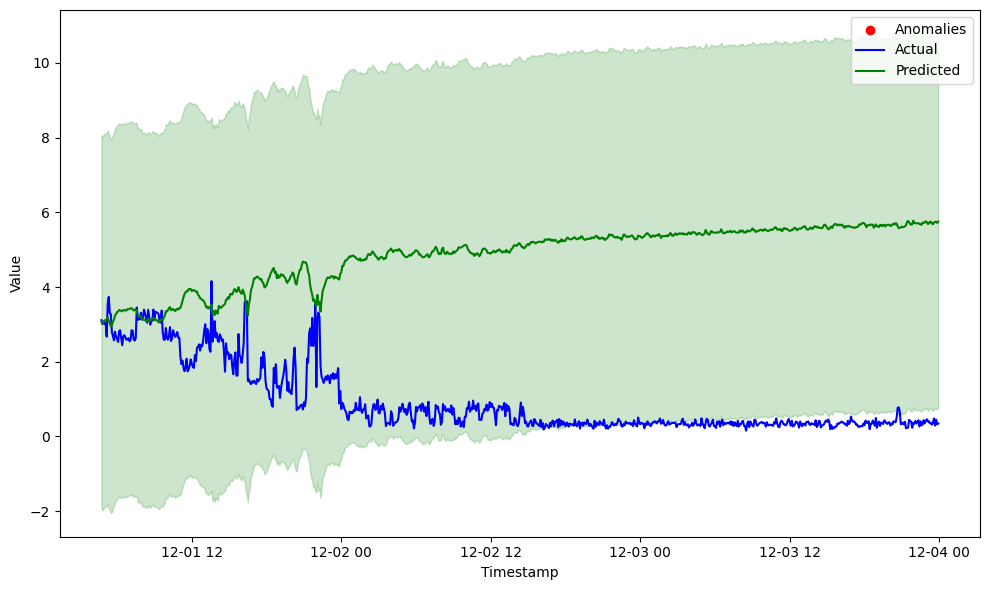

In [16]:
from forecasting_models.general_plotter import GeneralPlotter

GeneralPlotter.plot_anomalies(
    cpu_anomaly_df,
    5.0,
)

In [17]:
cpu_anomaly_df = varmax.flag_anomalies(
    test_result_df["cpu_usage_percentage_actual"],
    test_result_df["cpu_usage_percentage_predicted"],
    5.0,
    use_abs_diff=True,
)

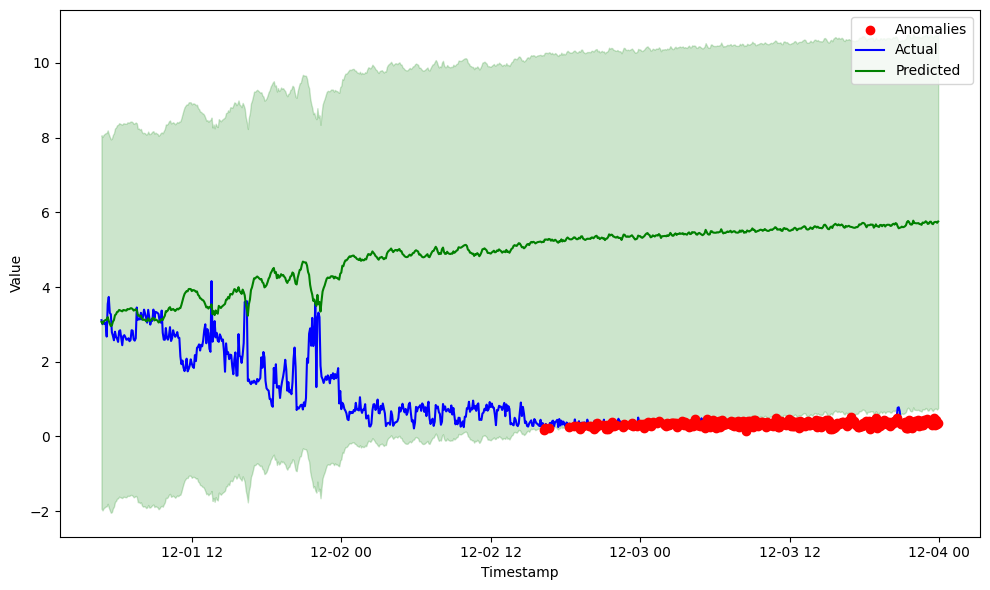

In [18]:
GeneralPlotter.plot_anomalies(
    cpu_anomaly_df,
    5.0,
)

In [19]:
mem_anomaly_df = varmax.flag_anomalies(
    test_result_df["mem_usage_percentage_actual"],
    test_result_df["mem_usage_percentage_predicted"],
    5.0,
)
mem_anomaly_df

,actual,predicted,diff,is_anomaly
2023-12-01 04:45:22,0.078752,0.078040,0.000711,0
2023-12-01 04:50:22,0.081700,0.077011,0.004689,0
2023-12-01 04:55:22,0.074745,0.073512,0.001233,0
2023-12-01 05:00:22,0.082209,0.076463,0.005746,0
2023-12-01 05:05:22,0.079055,0.074849,0.004206,0
...,...,...,...,...
2023-12-03 23:35:22,0.066109,0.041794,0.024315,0
2023-12-03 23:40:22,0.064881,0.042039,0.022842,0
2023-12-03 23:45:22,0.072169,0.041796,0.030373,0
2023-12-03 23:50:22,0.066762,0.034498,0.032264,0


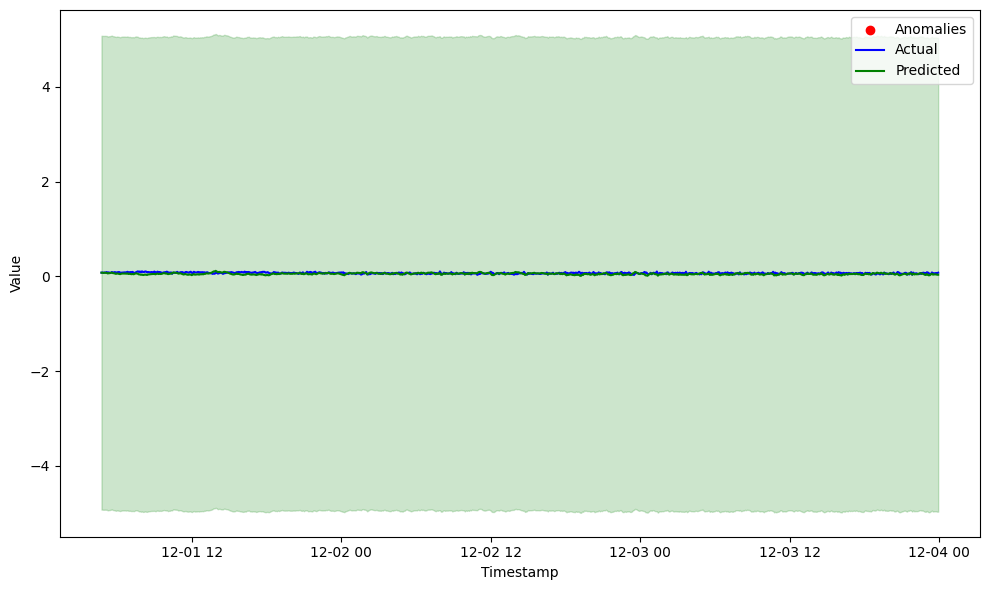

In [20]:
GeneralPlotter.plot_anomalies(
    mem_anomaly_df,
    5.0,
)